Перед началом работы над проектом импортируем необходимые инструменты:

In [1]:
# Установка и обновление необходимых библиотек:
!pip install --upgrade scikit-learn -q
!pip install lightgbm -q
!pip install catboost -q

In [2]:
# Импорт необходимых библиотек и модулей:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightgbm as lgb
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    RandomizedSearchCV,
    cross_validate
)

# Импорт моделей:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Импорт функции метрики:
from sklearn.metrics import root_mean_squared_error as rmse

from warnings import simplefilter

In [3]:
# Доп. настройка сетки для графиков:
sns.set_style("darkgrid", {'grid.color': 'gray'})

# Отключение предупреждений:
simplefilter(action='ignore', category=Warning)

## Ознакомление с данными

После импортирования необходимых инструментов считаем и сохраним полученный датасет. Далее проверим корректность считывания:

In [4]:
# Прочитаем и сохраним полученный датасет:
data = pd.read_csv('/datasets/taxi.csv')

# Проверка считывания:
data.head(3)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


Содержание столбцов соответствует их описанию. Названия столбцов корректы.

Выведем общую информацию о датасете, чтобы оценить степень заполненость данных и типы данных:

In [5]:
# Вывод общей информации:
print('Общая информация о датасете:\n')
data.info()

Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков нет. Столбец `datetime` не соответвует по типу данных. Изменим его на следующем этапе.

Проверим наш датасет на наличие **явных** дубликатов.

In [6]:
print(f'Кол-во явных дубликатов: {data.duplicated().sum()}')

Кол-во явных дубликатов: 0


### Вывод

На данном этапе:

- датафрейм был прочитан и сохранён;
- обнаружено несоответствие типа столбца с датой и временем;
- явных дубликатов нет;

Переходим к этапу подготовки данных.

## Подготовка

Подготовим данные к анализу и последующей передаче моделям МО.

Для начала изменим тип данных столбца `datetime`:

In [7]:
# Меняем тип данных:
data['datetime'] = data['datetime'].astype('datetime64')

# Проверка:
print(f'Тип данных столбца datetime: {data.datetime.dtype}')

Тип данных столбца datetime: datetime64[ns]


Установим этот столбец в качестве индекса нашего датасета:

In [8]:
# Делаем datetime индексом таблицы:
data.set_index('datetime', inplace=True)

# Проверка:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


Теперь необходимо проверить, соблюдён ли хронологический порядок даты и времени:

In [9]:
# Проверка:
if data.index.is_monotonic == True:
    print('Хронологический порядок соблюдён.')
else:
    print('Хронологический порядок нарушен.')

Хронологический порядок соблюдён.


Дополнительно можно посмотреть, какой период нам доступен:

In [10]:
print(f'Доступный промежуток от {data.index.min()} до {data.index.max()}')

Доступный промежуток от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


_Заказчиком были переданы данные от первого марта до 31 августа 2018 года, а это полгода._

Отлично, теперь проведём ресемплирование данных. На данный момент, похоже, что интервал равен 10 минутам. Убедимся в этом:

In [11]:
print(f'Значения минут в таблице: {data.index.minute.unique().values}')

Значения минут в таблице: [ 0 10 20 30 40 50]


Это действительно так. Увеличим интервал до 1 часа, а заказы в этот промежуток суммируем.

In [12]:
# Увеличение интервала:
data = data.resample('1H').sum()

# Проверка:
display(data.head())
print(f'Теперь строк: {data.shape[0]}.')

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь строк: 4416.


### Вывод

На данном этапе:

- Изменили тип данных у столбца, который впоследствии слелали индексом для удобства в будущей работе;
- Ресемплировали данные до 1 часа, суммируя все заказы за этот час.
- Количество отметок после ресемплирования снизилось до 4416шт.

Переходим к этапу анализа.

## Анализ

Рассмотрим основные числовые характеристики заказов:

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


1. Медианное среднее количество заказов в час — 78, так как есть выбросы и по 462 заказа за час.
2. Есть "нулевые" часы.

Можно дополнительно рассмотреть часы-выбросы.

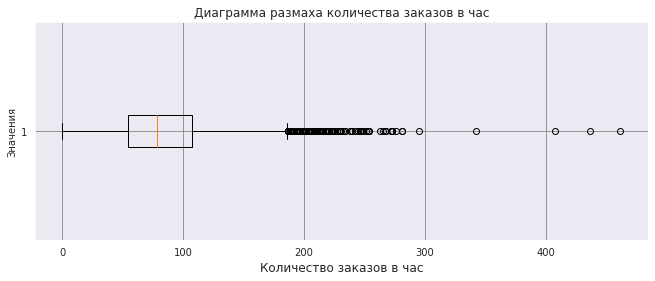

In [14]:
# Построение диаграммы размаха:
plt.figure(figsize=(11,4))
plt.boxplot(data, vert=False)
plt.title('Диаграмма размаха количества заказов в час')
plt.xlabel('Количество заказов в час', fontsize=12)
plt.ylabel('Значения')

plt.show()

Во временном ряде есть 3 отметки о свыше 400 заказов и 1 отметка о почти 350 заказов.

Построим общий график нашего временного ряда:

In [15]:
# Скопируем данные для удобства:
analyse = data.copy()

# Функция для построения графика:
def show_plot(data, size=(16, 5), title='Динамика количества заказов по времени',
              xlabel='Месяц', ylabel='Количество заказов', legend=[], xticks=None):
    plt.figure(figsize=size)
    plt.plot(data)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel)
    plt.legend(legend)
    
    if xticks == 'hours':
        plt.xticks(range(24))

    plt.show()

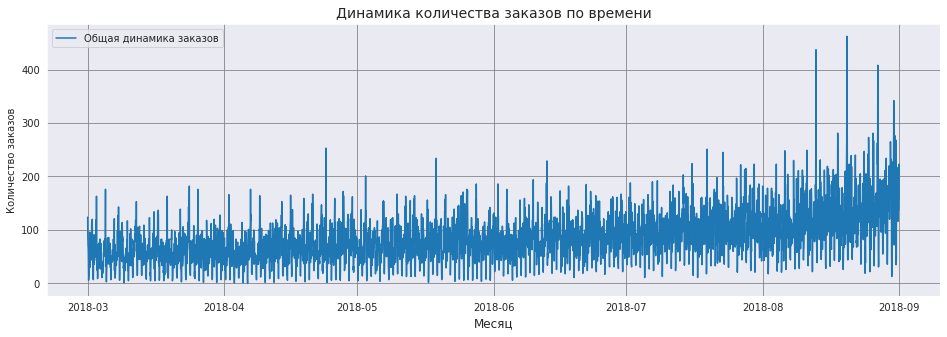

In [16]:
# Построение графика:
legend = ['Общая динамика заказов']
show_plot(analyse, legend=legend)

Похоже, с шестого месяца появляется тренд на увеличение среднего количества закзазов, график понемного идёт вверх. Проверим это с помощью скользящего среднего.

Для начала добавим его в ряд, а затем визуализируем.

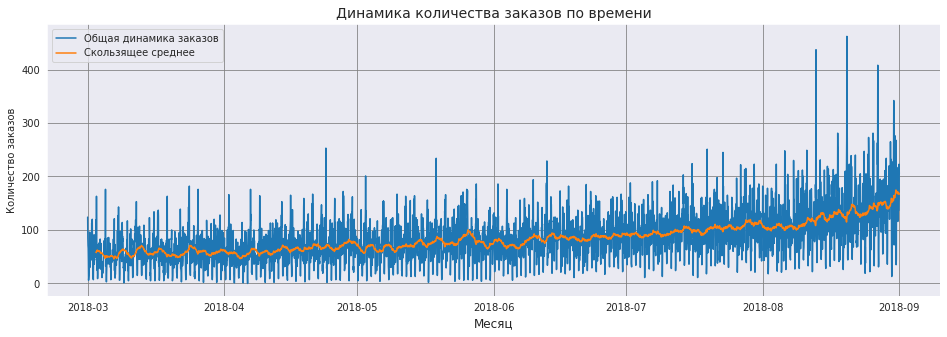

In [17]:
# Расчёт скользящего среднего:
analyse['rolling_mean'] = analyse.rolling(46).mean()
legend.append('Скользящее среднее')

# Построение графика:
show_plot(analyse, legend=legend)

Действительно, есть тренд на увеличение скользящего среднего. Посмотрим на изменение стандартного отклонения.

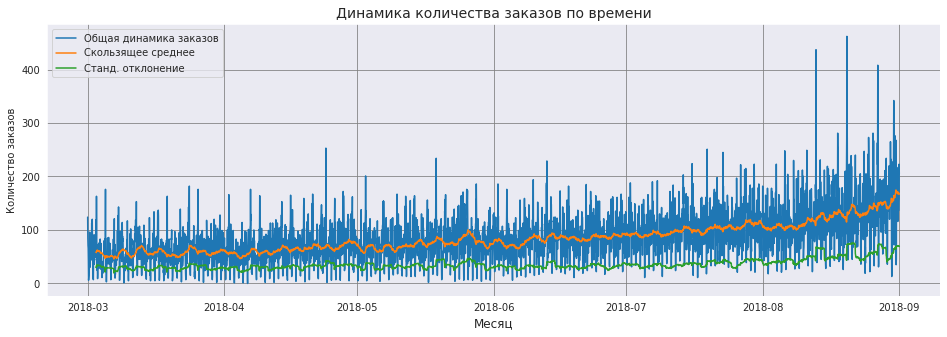

In [18]:
# Расчёт стандартного отклонения:
analyse['std'] = analyse['num_orders'].rolling(46).std()
legend.append('Станд. отклонение')

# Построение графика:
show_plot(analyse, legend=legend)

Стандартное отклонение так же немного начинает расти.<br>_Стоит также заметить, что в тестовую выборку попадут «нестабильные» данные, что усложнит проверку моделей._


**Проведём небольшой декомпозиционный анализ**:<br>Для более детального рассмотрения декомпозируем временной ряд на отдельные составляющие.

In [19]:
# Декомпозиция на составляющие:
decomposed = seasonal_decompose(data)

Рассмотрим отдельно _тренд_ и _сезонность_.

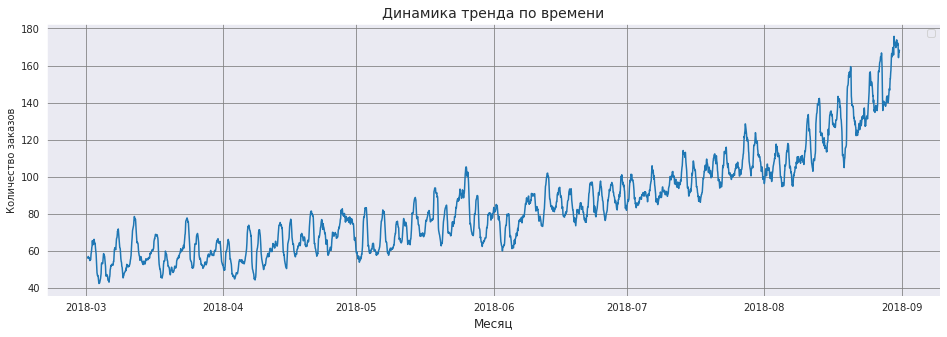

In [20]:
# Построение графика тренда:
show_plot(decomposed.trend, title='Динамика тренда по времени')

Тренд действительно меняется в бóльшую сторону. Похоже, что мы имеем дело с _нестационарным_ временным рядом, но нужна дополнительная проверка.

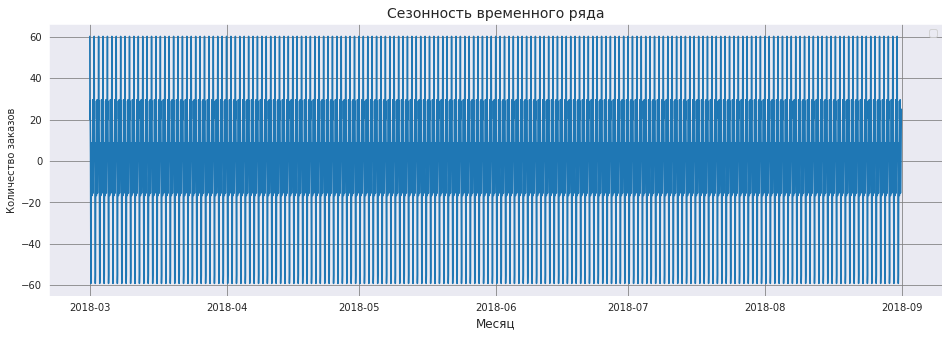

In [21]:
# Построение графика сезонности:
show_plot(decomposed.seasonal, title='Сезонность временного ряда')

Увеличим масштаб колебаний:

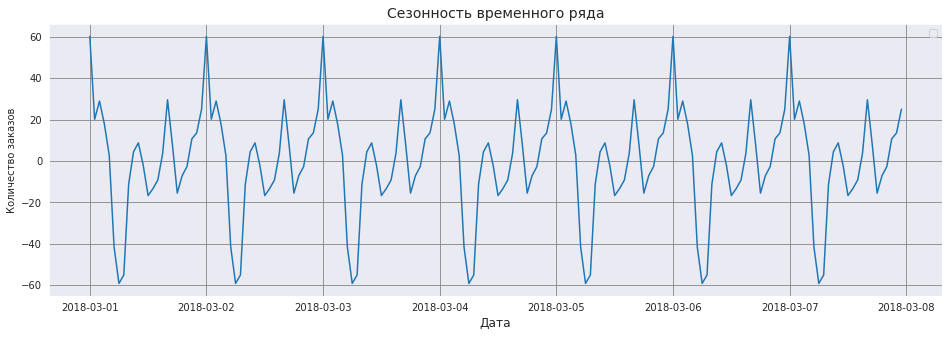

In [22]:
show_plot(
    decomposed.seasonal['2018-03-01':'2018-03-07'],
    title='Сезонность временного ряда',
    xlabel='Дата'
)

Наблюдаются идентичные _суточные_ колебания количества заказов. Количество заказов варьируется в зависимости от времени суток.<br>Углубимся в день временного ряда, чтобы узнать, какие часы выделяются динамикой заказов.

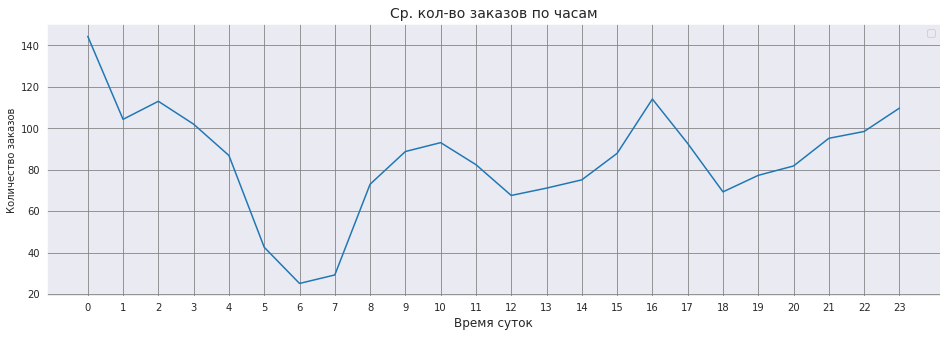

In [23]:
# Построение графика:
show_plot(
    data.pivot_table(
        index=data.index.hour.values,
        values='num_orders',
        aggfunc='mean'
    ), 
    title='Ср. кол-во заказов по часам',
    xlabel='Время суток',
    xticks='hours'
)

1. Больше всего заказов наблюдается в районе **12 часов ночи**.
2. Меньше всего — в районе **шести и семи утра**.
3. Дальше в течение дня пик заказов находится в районе **16 часов дня**.

Пик заказов в околоночное время можно объяснить прилётами в аэропорт в это время, что косвенно может быть связано с ценами на авиабилеты.

Также можно рассмотреть и шумы декомпозиции (остатки):

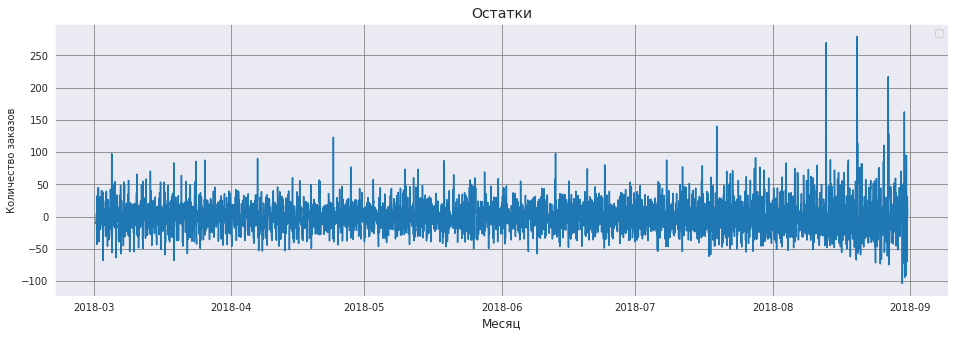

In [24]:
# Построение графика остатков:
show_plot(decomposed.resid, title='Остатки')

Эти значения случайны.

### Тест на стационарность

Чтобы окончательно определиться с дальнейшими действиями, проведём формальный тест `Дики — Фуллера (ADF)` для определения стационарности нашего временного ряда.

ADF-тест проверяет нулевую гипотезу (H0) о наличии нестационарности против альтернативной гипотезы (H1) о стационарности ряда.

In [25]:
# Функция на проведение ADF-теста:
def adf_test(data, alpha):
    result = adfuller(data)
    p_value = result[1]
    
    print('p-value =', p_value.round(3), '=>')
    
    if result[1] <= alpha:
        print('=> Отвергаем H0: ВР стационарен.')
    else:
        print('=> Не отвергаем H0: ВР нестационарен.')

Установим уровень статистической значимости на `5%` (alpha) и проведём тест.

In [26]:
# Проведение ADF-теста:
adf_test(data, alpha=.05)

p-value = 0.029 =>
=> Отвергаем H0: ВР стационарен.


Интересно. Наблюдения на графике говорят об обратном. Для уверенности проведём еще один формальный тест — `Квятковского-Филлипса-Шмидта-Шина (KPSS)`. Его нулевая гипотеза (H0) наоборот строится о наличии стацинарности временного ряда, а альтернативная (Н1) уже о нестационарности.

In [27]:
# Функция на проведение KPSS-теста:
def kpss_test(data, alpha):
    result = kpss(data)
    p_value = result[1]
    
    print('p-value =', p_value.round(3), '=>')
    
    if result[1] <= alpha:
        print('=> Отвергаем H0: ВР нестационарен.')
    else:
        print('=> Не отвергаем H0: ВР стационарен.')

Установим уровень статистической значимости на `5%` (alpha) и проведём тест.

In [28]:
# Проведение KPSS-теста:
kpss_test(data, alpha=.05)

p-value = 0.01 =>
=> Отвергаем H0: ВР нестационарен.


Скорее всего, мы имеем _нестационарный_ временной ряд. Фактическое наблюдение и KPSS-тест об этом говорят.<br> 2:1.

### Вывод

На данном этапе мы выяснили:

- Медианное среднее количество заказов в час — 78;
- Есть часы, в которых заказов вообще не зафиксировано. Есть и выбросы с количеством заказов > 200;
- Больше всего заказов наблюдается в районе 12 часов ночи.
- Меньше всего — в районе шести и семи утра.
- Дальше в течение дня пик заказов находится в районе 16 часов дня.
- Декомпозировали временной ряд на составляющие. Увидели рост тренда и наличие суточного колебания кол-ва заказов.
- Похоже, что мы имеем _нестационарный_ временной ряд. Тем более проверка моделей усложнится тем, что в тестовую выборку попадут «нестабильные данные».

## Подготовка данных к обучению

Перед тем, как передавать моделям выборки, создадим дополнительные признаки для обеспечения более качественного обучения.<br>Напишем для этого функцию:

In [29]:
def make_features(data, max_lag, window_size):
    # Создание календарных признаков:
    # Год не будем добавлять, т.к. такой признак будет бесполезен
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Создание отстающих значений:
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # Создание скользящего среднего:
    data['rolling_mean'] = data['num_orders'].shift().rolling(window_size).mean()

Теперь необходимо подготовить выборки:

In [30]:
# Функция для разделения на выборки:
def get_samples(time_series, target, test_size):
    
    # Тренировочная и валидационная:
    train, valid = train_test_split(
        time_series,
        test_size=test_size,
        shuffle=False
    )
    
    # Отделение тестовой:
    valid, test = train_test_split(
        valid,
        test_size=.5,
        shuffle=False
    )
    
    # Получение выборок:
    X_train = train.drop(target, axis=1)
    y_train = train[target]
    
    X_valid = valid.drop(target, axis=1)
    y_valid = valid[target]
    
    X_test = test.drop(target, axis=1)
    y_test = test[target]
    
    # Убираем пустые значения из обучающей выборки:
    X_train.dropna(inplace=True)
    
    # Исправляем несоответствие размеров:
    y_train = y_train[y_train.index.isin(X_train.index)]
    
    
    # Проверка:
    print('Размер тренировочной выборки: {:.0%}'.format(X_train.shape[0] / time_series.shape[0]))
    print('Размер валидационной выборки: {:.0%}'.format(X_valid.shape[0] / time_series.shape[0]))
    print('Размер тестовой выборки: {:.0%}'.format(X_test.shape[0] / time_series.shape[0]))
    print(f'\nКол-во пропусков в обучающих данных: {X_train.isna().sum().sum()}')
        
        
    return X_train, X_valid, X_test, y_train, y_valid, y_test

Создадим копию нашего временного ряда для удобства:

In [31]:
# Копирование и сохранение:
model_data = data.copy()

Приступим к созданию признаков и формированию выборок:

In [32]:
# Создание признаков:
make_features(model_data, max_lag=30, window_size=80)

In [33]:
# Получение выборок:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_samples(
    model_data,
    'num_orders',
    test_size=0.2
)

Размер тренировочной выборки: 78%
Размер валидационной выборки: 10%
Размер тестовой выборки: 10%

Кол-во пропусков в обучающих данных: 0


Можно дополнительно проверить правильность разделения ряда на выборки:

In [34]:
# Проверка хронологии выборок:
print(f'X_train: от {X_train.index.min()} до {X_train.index.max()}')
print(f'X_valid: от {X_valid.index.min()} до {X_valid.index.max()}')
print(f'X_test: от {X_test.index.min()} до {X_test.index.max()}')

X_train: от 2018-03-04 08:00:00 до 2018-07-26 03:00:00
X_valid: от 2018-07-26 04:00:00 до 2018-08-13 13:00:00
X_test: от 2018-08-13 14:00:00 до 2018-08-31 23:00:00


### Вывод

На данном этапе мы создали новые признаки для повышения качества обучения и сформировали выборки.

## Обучение моделей

### LinearRegression

В начале рассмотрим самую базовую лин. регрессию.<br>Данная модель без гиперпараметров, поэтому инициализируем её и проверим на кросс-валидации, чтобы оценка была более объективной.

In [35]:
# Инициализация инструмента кросс-валидации для временных рядов:
tscv = TimeSeriesSplit(n_splits=20)

In [36]:
# Инициализация модели:
model_lr = LinearRegression()

# Запускаем кросс-валидацию и сохраняем результаты:
lr_cv = cross_validate(
    model_lr,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

print('Метрика RMSE модели на кросс-валидации:',
      abs(lr_cv['test_score'].mean().round(2)))

Метрика RMSE модели на кросс-валидации: 24.43


Неплохой результат на кросс-валидации, посмотрим, как модель справится с валидационной выборкой.

In [37]:
# Обучение модели:
model_lr.fit(X_train, y_train)

# Получим значение её метрики на валидации:
rmse_lr = round(rmse(y_valid, model_lr.predict(X_valid)), 2)

# Вывод её метрики:
print(f'Метрика RMSE линрег-модели на валидационной выборке: {rmse_lr}')

Метрика RMSE линрег-модели на валидационной выборке: 33.94


Хм, значение метрики упало, но всё еще удовлетворяет требованию.

### LGBMRegressor

Для начала выделим категориальные признаки, чтобы затем передать их модели для внутреннего кодировщика, предварительно изменив тип данных:

In [38]:
# Выделяем категориальные признаки:
cat_col = list(X_train.columns[0:4])

Теперь можно изменить тип данных:

In [39]:
# Изменим тип данных с помощью цикла:
for column in cat_col:
    model_data[column] = model_data[column].astype('category')
    
# Проверка:
print('Новые типы данных у признаков:\n')
print(model_data[cat_col].dtypes)

Новые типы данных у признаков:

month        category
day          category
dayofweek    category
hour         category
dtype: object


Сформируем для неё выборки ещё раз:

In [40]:
# Получение выборок:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_samples(model_data, 'num_orders', test_size=0.2)

Размер тренировочной выборки: 78%
Размер валидационной выборки: 10%
Размер тестовой выборки: 10%

Кол-во пропусков в обучающих данных: 0


Произведём инициализацию модели, зададим значения её гиперпараметров для перебора:

In [41]:
# Изменим значение параметра разбивки на подвыборки:
tscv = TimeSeriesSplit(n_splits=5)

# Инициализация модели:
lgb_model = lgb.LGBMRegressor(
    n_estimators=120,
    learning_rate=0.8,
    random_state=42,
    n_jobs=-1,
    categorical_features=cat_col
)

# Задаём ГП для перебора:
lgb_params = {
    'max_depth': [5, 8, 10],
    'reg_alpha': [0.1, 0.2]
}

Передадим инструменту `RandomizedSearchCV` нашу модель и диапазоны ГП:

In [42]:
# Инициализация инструмента подбора:
lgb_rs = RandomizedSearchCV(
    lgb_model,
    lgb_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    n_iter=5,
    random_state=42,
    verbose=3
)

Запустим перебор гиперпараметров, там же будем проводить валидацию модели:

In [43]:
# Интересно, сколько займёт подбор и валидация:
start_lgb_rs = time.time()

# Запускаем подбор ГП и валидацию:
lgb_rs.fit(X_train, y_train, verbose=20)

end_lgb_rs = time.time()
time_spent = end_lgb_rs - start_lgb_rs

print(f'\n\nВремя на поиск и кросс-валидацию составило: {round(time_spent, 2)} c.')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......max_depth=5, reg_alpha=0.1;, score=-26.780 total time=   1.3s
[CV 2/5] END ......max_depth=5, reg_alpha=0.1;, score=-26.611 total time=   2.1s
[CV 3/5] END ......max_depth=5, reg_alpha=0.1;, score=-27.774 total time=   1.0s
[CV 4/5] END ......max_depth=5, reg_alpha=0.1;, score=-30.393 total time=   0.8s
[CV 5/5] END ......max_depth=5, reg_alpha=0.1;, score=-31.476 total time=   1.1s
[CV 1/5] END ......max_depth=5, reg_alpha=0.2;, score=-26.823 total time=   0.5s
[CV 2/5] END ......max_depth=5, reg_alpha=0.2;, score=-26.265 total time=   1.6s
[CV 3/5] END ......max_depth=5, reg_alpha=0.2;, score=-27.458 total time=   0.8s
[CV 4/5] END ......max_depth=5, reg_alpha=0.2;, score=-29.700 total time=   0.9s
[CV 5/5] END ......max_depth=5, reg_alpha=0.2;, score=-30.505 total time=   1.0s
[CV 1/5] END .....max_depth=10, reg_alpha=0.2;, score=-24.813 total time=   0.5s
[CV 2/5] END .....max_depth=10, reg_alpha=0.2;, s

Сохраним лучшую модель отдельно и посмотрим её метрику.

In [44]:
# Сохранение лучшей модели:
best_lgb = lgb_rs.best_estimator_

# Получим значение её метрики на валидации:
rmse_lgb = round(rmse(y_valid, best_lgb.predict(X_valid)), 2)

# Вывод её метрики:
print(f'Метрика RMSE лучшей LGB-модели на валидационной выборке: {rmse_lgb}')

Метрика RMSE лучшей LGB-модели на валидационной выборке: 37.54


Интересно, что данная модель на валидации справилась чуть хуже, чем обычная лин. регрессия.

### CatBoostRegressor

Для этой модели уже не требуется тип `category` для категориальных признаков. Сформируем выборки для неё:

In [45]:
# Получение выборок:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_samples(model_data, 'num_orders', test_size=0.2)

Размер тренировочной выборки: 78%
Размер валидационной выборки: 10%
Размер тестовой выборки: 10%

Кол-во пропусков в обучающих данных: 0


Проведём инициализацию и зададим гиперпараметры для поиска:

In [46]:
# Инициализация модели:
catboost_model = CatBoostRegressor(
    max_leaves=40,
    cat_features=cat_col,
    random_state=42,
    grow_policy='Lossguide'
)

cat_params = {
    'learning_rate': [0.8, 0.9]
}

Изменим также количество разбиений на подвыборки в `TimeSeriesSplit`.

In [47]:
# Изменим значение параметра:
tscv = TimeSeriesSplit(n_splits=3)

# Инициализация инструмента подбора:
catboost_rs = RandomizedSearchCV(
    catboost_model,
    cat_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    n_iter=3,
    random_state=42,
    verbose=15
)

In [48]:
# Запускаем подбор ГП и валидацию:
start_cat_rs = time.time()

catboost_rs.fit(X_train, y_train, verbose=False)

end_cat_rs = time.time()
time_spent = end_cat_rs - start_cat_rs

print(f'\n\nВремя на поиск и кросс-валидацию составило: {round(time_spent, 2)} c.')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START learning_rate=0.8...........................................
[CV 1/3; 1/2] END ..........learning_rate=0.8;, score=-26.201 total time=  13.4s
[CV 2/3; 1/2] START learning_rate=0.8...........................................
[CV 2/3; 1/2] END ..........learning_rate=0.8;, score=-27.681 total time=  16.7s
[CV 3/3; 1/2] START learning_rate=0.8...........................................
[CV 3/3; 1/2] END ..........learning_rate=0.8;, score=-31.266 total time=  19.8s
[CV 1/3; 2/2] START learning_rate=0.9...........................................
[CV 1/3; 2/2] END ..........learning_rate=0.9;, score=-26.835 total time=  12.1s
[CV 2/3; 2/2] START learning_rate=0.9...........................................
[CV 2/3; 2/2] END ..........learning_rate=0.9;, score=-28.677 total time=  17.1s
[CV 3/3; 2/2] START learning_rate=0.9...........................................
[CV 3/3; 2/2] END ..........learning_rate=0.9;, sc

Сохраним отдельно лучшую модель и опробуем её на валидационной выборке:

In [49]:
# Сохранение лучшей модели:
best_cat = catboost_rs.best_estimator_

# Получим значение её метрики на валидации:
rmse_cat = round(rmse(y_valid, best_cat.predict(X_valid)), 2)

# Вывод её метрики:
print(f'Метрика RMSE лучшей CatBoost-модели на валидационной выборке: {rmse_cat}')

Метрика RMSE лучшей CatBoost-модели на валидационной выборке: 38.19


Что ж, эта модель справилась ещё хуже, чем обе предыдущие.

### Проверка на адекватность

Проверим наши модели на адекватность предсказаниями `предыдущими значениями ряда`. Сделаем это для всех моделей с помощью функции:

In [50]:
# Функция для проверки модели:
def check_model(metric):

    # Получение дамми-предсказаний:
    dummy_pred = y_valid.shift(fill_value=y_train[-1])
    
    # Получение метрики:
    rmse_dummy = rmse(y_valid, dummy_pred)
    
    # Презентация результатов:
    print('Метрика RMSE дамми-модели на валидационной выборке:',
      round(rmse_dummy, 2), '=>')
    
    if rmse_dummy > metric:
        print('=> Модель прошла проверку на адекватность.')
    else:
        print('=> Модель НЕ прошла проверку на адекватность.')

Проверяем:

In [51]:
# Проверка линейной регрессии:
check_model(rmse_lr)

Метрика RMSE дамми-модели на валидационной выборке: 47.25 =>
=> Модель прошла проверку на адекватность.


In [52]:
# Проверка LGB-модели:
check_model(rmse_lgb)

Метрика RMSE дамми-модели на валидационной выборке: 47.25 =>
=> Модель прошла проверку на адекватность.


In [53]:
# Проверка CatBoost-модели: 
check_model(rmse_cat)

Метрика RMSE дамми-модели на валидационной выборке: 47.25 =>
=> Модель прошла проверку на адекватность.


Таким образом, все модели прошли проверку на адекватность. Занятно, что дамми-предсказания уложились в диапазон метрики от заказчика.

Лучшую модель выберем по значению метрики, т.к. от заказчика не поступало требований по каким-либо еще критериям.

In [54]:
# Формирование результата в табличном виде:
results = {'RMSE': [rmse_lr, rmse_lgb, rmse_cat]}

index = ['LinearRegression', 'LGBMRegressor', 'CatBoostRegressor']

results = pd.DataFrame(data=results, index=index)

# Вывод:
results.sort_values(by='RMSE')

,RMSE
LinearRegression,33.94
LGBMRegressor,37.54
CatBoostRegressor,38.19


Как ни странно, валидационные результаты `линейной регрессии` показали себя лучше других, хоть и несильно. Проверим её на тестовых данных в следующем этапе.

### Вывод

1. Мы подготовили выборки, обучили и проверили на валидации три модели МО: линейную регрессию, LGBM-регрессор и CatBoost-регрессор. Перед этим мы добавили новые признаки обучающую выборку.
2. Все модели прошли проверку на адекватность.
3. Лучшей при валидации показала себя модель `линейной регрессии`. Посмотрим, как она справится с проблемной тестовой выборкой на следующем этапе.

## Тестирование

Время сынициировать вывод модели в прод. Передадим лучшей модели _тестовые_ данные для получения предсказаний.

In [55]:
# Получение предсказаний:
y_pred = model_lr.predict(X_test)

# Получим значение метрики:
best_lr_rmse = round(rmse(y_test, y_pred), 2)

# Вывод результата:
print(f'Метрика RMSE лучшей модели на тестовой выборке: {best_lr_rmse}')

Метрика RMSE лучшей модели на тестовой выборке: 47.57


Модель справилась с нестабильной тестовой выборкой.

## Общий вывод

В данной проектной работе перед нами стояла задача **построить модель МО**, которая сможет предсказывать количество заказов на следующий час для компании-заказчика «Чётенькое такси».

_Для решения этой задачи были проделаны следующие этапы:_

1. Исходные данные представляли собой датасет с двумя признаками для наблюдений. С ними **мы ознакомились**, подтвердили соответствие их описанию. Не обнаружили явных дубликатов, только подправили тип данных у временного признака.


2. **Датасет был преобразован** для удобства в работе, временной признак стал индексом. Мы проверили его хронологическую последовательность и с этим всё в порядке.


3. Далее **данные были ресемплированы** согласно требованиям задачи. После группировки по часам количество наблюдений **снизилось** до 4416шт.


4. Вот некоторые результаты _исследовательского анализа_:
    - Медианное среднее количество заказов в час — 78;
    - Есть часы, в которых заказов вообще не зафиксировано. Есть и выбросы с количеством заказов > 200;
    - Больше всего заказов наблюдается в районе 12 часов ночи.
    - Меньше всего — в районе шести и семи утра.
    - Дальше в течение дня пик заказов находится в районе 16 часов дня.


5. Необходимо было **оценить стационарность** полученного временного ряда. Столкнулись с трудностями в определении стационарности, в связи с чем было проведено пару тестов вместе с визуальным. Похоже, временной ряд всё-таки нестационарный, либо имеет низкую стационарность.


6. Для увеличения качетсва будущего обучения моделей **были добавлены новые признаки**: `календарные`, `отстающие значения` и `скользящие средние`.


7. Мы **подготовили выборки** (_тестовая составляла 10%_ от всех данных), **обучили и проверили** на валидации три модели МО: `линейную регрессию`, `GBM-регрессор` и `CatBoost-регрессор`. Все модели прошли проверку на адекватность. Лучшей при валидации показала себя модель **`линейной регрессии`**.


8. На этапе вывода в прод **модель** также **уложилась в необходимые требования** по метрике. Она показала значение RMSE =  **47.57**.